# Importation des bibliothèques nécessaires

In [13]:

import pandas as pd  # Manipulation et analyse de données sous forme de DataFrame
import numpy as np  # Calculs numériques et manipulation de tableaux
import matplotlib.pyplot as plt  # Visualisation graphique
import seaborn as sns  # Visualisation avancée et esthétique

# Bibliothèques pour l'analyse des séries temporelles
from statsmodels.tsa.stattools import adfuller  # Test de Dickey-Fuller pour la stationnarité
from statsmodels.tsa.seasonal import seasonal_decompose  # Décomposition des séries temporelles
from statsmodels.tsa.arima.model import ARIMA  # Modèle ARIMA (AutoRegressive Integrated Moving Average)
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Modèle SARIMA (saisonnier)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [14]:
#importation des donner
df = pd.read_csv('detection.csv')

In [15]:
start_time = "2024-01-01 00:00:00" # Modifiez ceci pour qu'il corresponde à la date de début réelle de votre ensemble de données
df["timestamp"] = pd.to_datetime(start_time) + pd.to_timedelta(df["step"], unit="h")


In [16]:
df

,Unnamed: 0,step,sum_fraud,sum_transaction,timestamp
0,0,1.0,16.0,2708.0,2024-01-01 01:00:00
1,1,2.0,8.0,1014.0,2024-01-01 02:00:00
2,2,3.0,4.0,552.0,2024-01-01 03:00:00
3,3,4.0,10.0,565.0,2024-01-01 04:00:00
4,4,5.0,6.0,665.0,2024-01-01 05:00:00
...,...,...,...,...,...
734,734,735.0,12.0,12.0,2024-01-31 15:00:00
735,735,736.0,14.0,14.0,2024-01-31 16:00:00
736,736,737.0,10.0,10.0,2024-01-31 17:00:00
737,737,738.0,10.0,10.0,2024-01-31 18:00:00


# decomposition de la serie temporelle

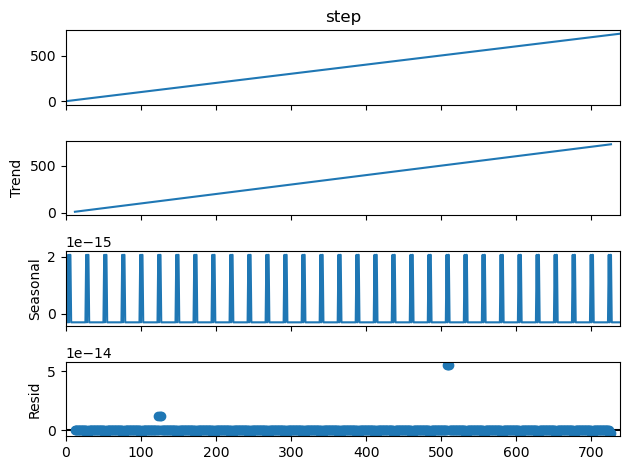

In [17]:
# Décomposition de la série temporelle en ses différentes composantes
# Cela permet d'analyser la tendance, la saisonnalité et les résidus
decomposition = seasonal_decompose(df["step"], model="additive", period=24)  
# Utilisation d'un modèle additif (somme des composantes) avec une période de 24 (hypothèse de saisonnalité journalière)

# Affichage des composantes décomposées
decomposition.plot()  
plt.show()  # Affichage du graphique

# verification de la stationaritee

In [18]:
def check_stationarity(timeseries):
    # Effectue le test de Dickey-Fuller augmenté sur la série temporelle donnée
    result = adfuller(timeseries.dropna())  # Supprime les valeurs manquantes avant d'exécuter le test
    
    # Affiche la statistique du test ADF
    print("Statistique ADF :", result[0])
    
    # Affiche la p-value pour déterminer la stationnarité
    print("p-value :", result[1])
    
    # Vérifie si la p-value est supérieure à 0.05 (seuil couramment utilisé pour ce test)
    if result[1] > 0.05:
        print("Les données ne sont pas stationnaires.")  # Données non stationnaires = tendance ou saisonnalité
    else:
        print("Les données sont stationnaires.")  # Données stationnaires = propriétés statistiques constantes dans le temps

# Appelle la fonction pour tester la stationnarité sur la colonne 'sum_fraud' du DataFrame
check_stationarity(df['sum_fraud'])


Statistique ADF : -26.4831499651078
p-value : 0.0
Les données sont stationnaires.


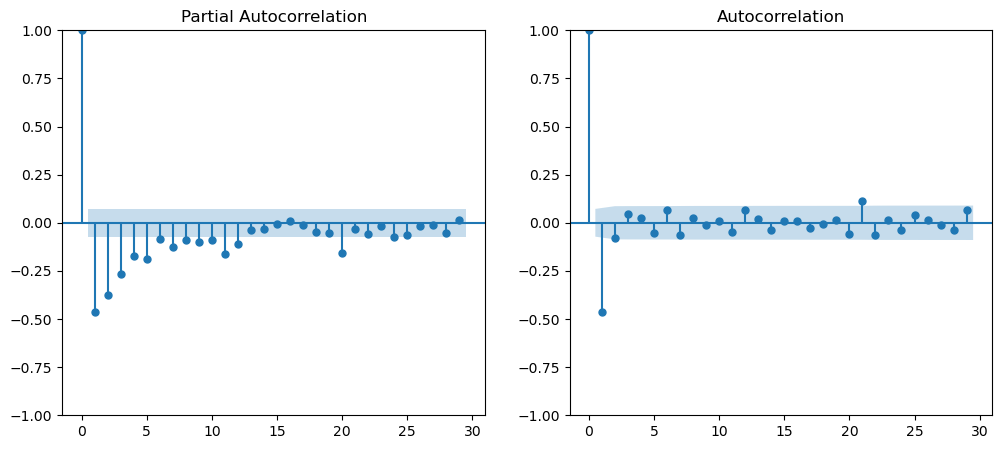

In [19]:
# Importation des bibliothèques nécessaires
# Crée une nouvelle colonne qui contient la différence entre les valeurs consécutives de "sum_fraud"
df["fraud_diff"] = df["sum_fraud"].diff()  # Utilisé pour transformer une série non stationnaire en stationnaire

# Crée une figure avec 2 sous-graphiques côte à côte
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  

# Trace la fonction d'autocorrélation partielle (PACF) pour analyser les dépendances directes
plot_pacf(df["fraud_diff"].dropna(), ax=ax[0])  # On supprime les valeurs NaN avant d'afficher le graphique

# Trace la fonction d'autocorrélation (ACF) pour examiner la structure de corrélation
plot_acf(df["fraud_diff"].dropna(), ax=ax[1])  # Même traitement ici pour éviter les erreurs

# Affiche les graphiques
plt.show()


# entrainement du modele

In [20]:
# Définition du modèle SARIMA avec une forte composante saisonnière
model = SARIMAX(df['sum_fraud'],  
                order=(1, 1, 1),  # Petit modèle ARIMA : 1 auto-régression, 1 différenciation, 1 moyenne mobile
                seasonal_order=(1, 1, 0, 24),  # Capture une saisonnalité sur 24 périodes (ex : 24 heures pour des données horaires)
                enforce_stationarity=False,  # Permet au modèle d'estimer des processus non stationnaires
                enforce_invertibility=False)  # Permet d'estimer des processus potentiellement non inversibles

# Entraînement du modèle sur les données
sarima_result = model.fit()  

# Affichage du résumé des résultats du modèle
print(sarima_result.summary())  


                                      SARIMAX Results                                      
Dep. Variable:                           sum_fraud   No. Observations:                  739
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 24)   Log Likelihood               -2237.900
Date:                             Mon, 17 Mar 2025   AIC                           4483.801
Time:                                     23:42:26   BIC                           4501.942
Sample:                                          0   HQIC                          4490.818
                                             - 739                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0265      0.038      0.698      0.485      -0.048       0.101
ma.L1         -1.0000      

# evaluation du modele

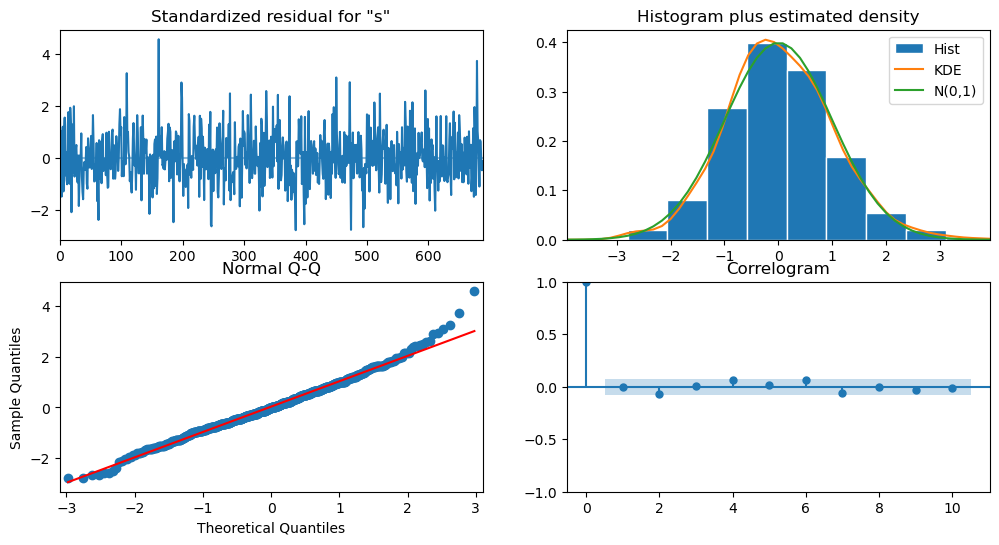

In [21]:
# Tracer les diagnostics du modèle pour évaluer son ajustement
sarima_result.plot_diagnostics(figsize=(12,6))  

# Afficher les graphiques de diagnostic
plt.show()

# prévisions sur 10 jours avec des données horaires

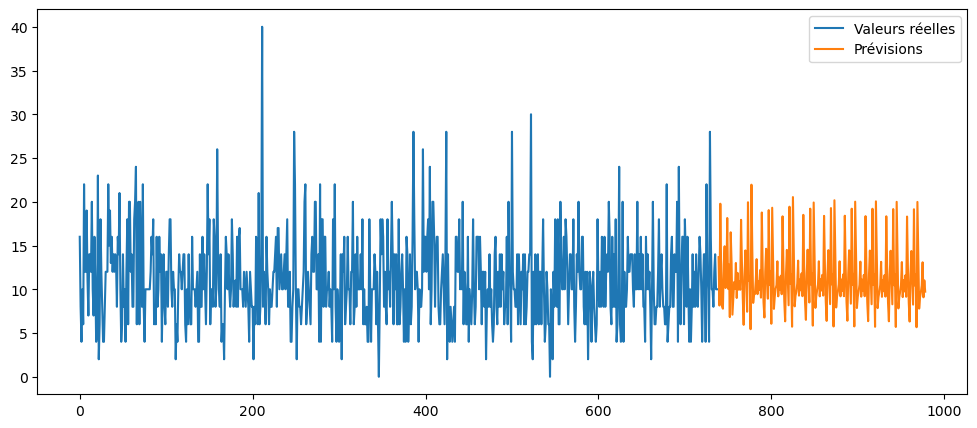

In [22]:
# Définition du nombre de pas dans le futur (prévisions sur 10 jours avec des données horaires)
future_steps = 24 * 10  # Prédiction pour les prochaines 24 heures * 10 jours

# Génération des prévisions pour les transactions frauduleuses
forecast = sarima_result.get_forecast(steps=future_steps)

# Obtention des intervalles de confiance des prévisions
forecast_df = forecast.conf_int()  # Fournit les bornes inférieure et supérieure des prédictions
forecast_df["Prediction"] = forecast.predicted_mean  # Ajout des valeurs prédites dans le DataFrame

# Tracé des résultats
plt.figure(figsize=(12,5))  
plt.plot(df['sum_fraud'], label="Valeurs réelles")  # Série temporelle réelle
plt.plot(forecast_df["Prediction"], label="Prévisions")  # Prévisions du modèle
plt.legend()  # Ajout de la légende pour distinguer les courbes
plt.show()  # Affichage du graphique
